# Homework and bake-off: Word relatedness

In [ ]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2021"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Development dataset](#Development-dataset)
  1. [Vocabulary](#Vocabulary)
  1. [Score distribution](#Score-distribution)
  1. [Repeated pairs](#Repeated-pairs)
1. [Evaluation](#Evaluation)
1. [Error analysis](#Error-analysis)
1. [Homework questions](#Homework-questions)
  1. [PPMI as a baseline [0.5 points]](#PPMI-as-a-baseline-[0.5-points])
  1. [Gigaword with LSA at different dimensions [0.5 points]](#Gigaword-with-LSA-at-different-dimensions-[0.5-points])
  1. [t-test reweighting [2 points]](#t-test-reweighting-[2-points])
  1. [Pooled BERT representations [1 point]](#Pooled-BERT-representations-[1-point])
  1. [Learned distance functions [2 points]](#Learned-distance-functions-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bake-off [1 point]](#Bake-off-[1-point])
1. [Submission Instruction](#Submission-Instruction)

## Overview

Word similarity and relatedness datasets have long been used to evaluate distributed representations. This notebook provides code for conducting such analyses with a new word relatedness datasets. It consists of word pairs, each with an associated human-annotated relatedness score. 

The evaluation metric for each dataset is the [Spearman correlation coefficient $\rho$](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the annotated scores and your distances, as is standard in the literature.

This homework ([questions at the bottom of this notebook](#Homework-questions)) asks you to write code that uses the count matrices in `data/vsmdata` to create and evaluate some baseline models. The final question asks you to create your own original system for this task, using any data you wish. This accounts for 9 of the 10 points for this assignment.

For the associated bake-off, we will distribute a new dataset, and you will evaluate your original system (no additional training or tuning allowed!) on that datasets and submit your predictions. Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points.

## Set-up

In [38]:
from collections import defaultdict
import csv
import itertools
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import spearmanr

import vsm
import utils

In [39]:
utils.fix_random_seeds()

In [40]:
VSM_HOME = os.path.join('data', 'vsmdata')

DATA_HOME = os.path.join('data', 'wordrelatedness')

## Development dataset

You can use development dataset freely, since our bake-off evalutions involve a new test set.

In [41]:
dev_df = pd.read_csv(
    os.path.join(DATA_HOME, "cs224u-wordrelatedness-dev.csv"))

The dataset consists of word pairs with scores:

In [42]:
dev_df.head()

,word1,word2,score
0,abandon,button,0.18
1,abandon,consigning,0.40
2,abandon,crane,0.16
3,abandon,ditch,0.63
4,abandon,left,0.57


This gives the number of word pairs in the data:

In [43]:
dev_df.shape[0]

4756

The test set will contain 1500 word pairs with scores of the same type. No word pair in the development set appears in the test set, but some of the individual words are repeated in the test set.

### Vocabulary

The full vocabulary in the dataframe can be extracted as follows:

In [44]:
dev_vocab = set(dev_df.word1.values) | set(dev_df.word2.values)

In [45]:
len(dev_vocab)

2809

The vocabulary for the bake-off test is different – it is partly overlapping with the above. If you want to be sure ahead of time that your system has a representation for every word in the dev and test sets, then you can check against the vocabularies of any of the VSMs in `data/vsmdata` (which all have the same vocabulary). For example:

In [46]:
task_index = pd.read_csv(
    os.path.join(VSM_HOME, 'yelp_window5-scaled.csv.gz'),
    usecols=[0], index_col=0)

full_task_vocab = list(task_index.index)

In [47]:
len(full_task_vocab)

6000

If you can process every one of those words, then you are all set. Alternatively, you can wait to see the test set and make system adjustments to ensure that you can process all those words. This is fine as long as you are not tuning your predictions.

### Score distribution

All the scores fall in $[0, 1]$, and the dataset skews towards words with low scores, meaning low relatedness:

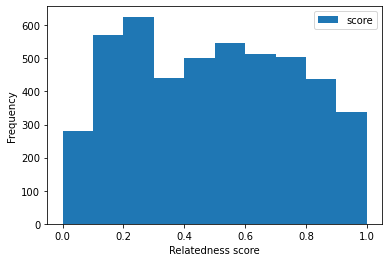

In [48]:
ax = dev_df.plot.hist().set_xlabel("Relatedness score")

### Repeated pairs

The development data has some word pairs with multiple distinct scores in it. Here we create a `pd.Series` that contains these word pairs:

In [49]:
repeats = dev_df.groupby(['word1', 'word2']).apply(lambda x: x.score.var())

repeats = repeats[repeats > 0].sort_values(ascending=False)

repeats.name = 'score variance'

In [50]:
repeats.shape[0]

279

The `pd.Series` is sorted with the highest variance items at the top:

In [51]:
repeats.head()

word1    word2     
buck     dollar        0.378592
furnace  stove         0.274653
cash     money         0.247104
boxing   round         0.189342
money    possession    0.187652
Name: score variance, dtype: float64

Since this is development data, it is up to you how you want to handle these repeats. The test set has no repeated pairs in it.

## Evaluation

Our evaluation function is `vsm.word_relatedness_evaluation`. Its arguments:
    
1. A relatedness dataset `pd.DataFrame` – e.g., `dev_df` as given above.
1. A VSM `pd.DataFrame` – e.g., `giga5` or some transformation thereof, or a GloVe embedding space, or something you have created on your own. The function checks that you can supply a representation for every word in `dev_df` and raises an exception if you can't.
1. Optionally a `distfunc` argument, which defaults to `vsm.cosine`.

The function returns a tuple:

1. A copy of `dev_df` with a new column giving your predictions.
1. The Spearman $\rho$ value (our primary score).

Important note: Internally, `vsm.word_relatedness_evaluation` uses `-distfunc(x1, x2)` as its score, where `x1` and `x2` are vector representations of words. This is because the scores in our data are _positive_ relatedness scores, whereas we are assuming that `distfunc` is a _distance_ function.

Here's a simple illustration using one of our count matrices:

In [52]:
count_df = pd.read_csv(
    os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)

In [53]:
count_pred_df, count_rho = vsm.word_relatedness_evaluation(dev_df, count_df)

In [54]:
count_rho

0.2776320615138188

In [55]:
count_pred_df.head()

,word1,word2,score,prediction
0,abandon,button,0.18,-0.336291
1,abandon,consigning,0.40,-0.085422
2,abandon,crane,0.16,-0.307229
3,abandon,ditch,0.63,-0.211550
4,abandon,left,0.57,-0.337866


It's instructive to compare this against a truly random system, which we can create by simply having a custom distance function that returns a random number in [0, 1] for each example, making no use of the VSM itself:

In [56]:
def random_scorer(x1, x2):
    """`x1` and `x2` are vectors, to conform to the requirements
    of `vsm.word_relatedness_evaluation`, but this function just
    returns a random number in [0, 1]."""
    return random.random()

In [57]:
random_pred_df, random_rho = vsm.word_relatedness_evaluation(
    dev_df, count_df, distfunc=random_scorer)

random_rho

-0.00059854523902375

This is a truly baseline system!

## Error analysis

For error analysis, we can look at the words with the largest delta between the gold score and the distance value in our VSM. We do these comparisons based on ranks, just as with our primary metric (Spearman $\rho$), and we normalize both rankings so that they have a comparable number of levels.

In [58]:
def error_analysis(pred_df):
    pred_df = pred_df.copy()
    pred_df['relatedness_rank'] = _normalized_ranking(pred_df.prediction)
    pred_df['score_rank'] = _normalized_ranking(pred_df.score)
    pred_df['error'] =  abs(pred_df['relatedness_rank'] - pred_df['score_rank'])
    return pred_df.sort_values('error')


def _normalized_ranking(series):
    ranks = series.rank(method='dense')
    return ranks / ranks.sum()

Best predictions:

In [59]:
error_analysis(count_pred_df).head()

,word1,word2,score,prediction,relatedness_rank,score_rank,error
3121,health,psychology,0.325000,-0.238147,0.000127,0.000127,3.284913e-08
2984,grey,purple,0.660000,-0.125642,0.000283,0.000283,3.895284e-08
2439,eye,organ,0.789141,-0.073605,0.000361,0.000361,6.168281e-08
3591,losses,play,0.543103,-0.163590,0.000223,0.000222,1.214181e-07
239,appearance,image,0.535000,-0.166412,0.000218,0.000218,1.518298e-07


Worst predictions:

In [60]:
error_analysis(count_pred_df).tail()

,word1,word2,score,prediction,relatedness_rank,score_rank,error
4643,submit,yield,0.916750,-0.473501,1.440789e-05,0.000423,0.000408
1010,bulletin,news,0.925926,-0.503304,1.082946e-05,0.000425,0.000414
4091,photo,picture,0.920000,-0.632888,2.165892e-06,0.000423,0.000421
3001,grow,sprouting,0.950000,-0.518391,9.134414e-06,0.000430,0.000421
4338,repeating,replicate,0.925000,-0.728052,3.766768e-07,0.000424,0.000424


## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### PPMI as a baseline [0.5 points]

The insight behind PPMI is a recurring theme in word representation learning, so it is a natural baseline for our task. This question asks you to write code for conducting such experiments.

Your task: write a function called `run_giga_ppmi_baseline` that does the following:

1. Reads the Gigaword count matrix with a window of 20 and a flat scaling function into a `pd.DataFrame`, as is done in the VSM notebooks. The file is `data/vsmdata/giga_window20-flat.csv.gz`, and the VSM notebooks provide examples of the needed code.
1. Reweights this count matrix with PPMI.
1. Evaluates this reweighted matrix using `vsm.word_relatedness_evaluation` on `dev_df` as defined above, with `distfunc` set to the default of `vsm.cosine`.
1. Returns the return value of this call to `vsm.word_relatedness_evaluation`.

The goal of this question is to help you get more familiar with the code in `vsm` and the function `vsm.word_relatedness_evaluation`.

The function `test_run_giga_ppmi_baseline` can be used to test that you've implemented this specification correctly.

In [61]:
def run_giga_ppmi_baseline():
    pass
    ##### YOUR CODE HERE
    raw_data = pd.read_csv(os.path.join(VSM_HOME, 'giga_window20-flat.csv.gz'), index_col=0)
    data_ppmi = vsm.pmi(raw_data, positive=True)
    return vsm.word_relatedness_evaluation(dev_df, data_ppmi)


In [62]:
def test_run_giga_ppmi_baseline(func):
    """`func` should be `run_giga_ppmi_baseline"""
    pred_df, rho = func()
    rho = round(rho, 3)
    expected = 0.586
    assert rho == expected, \
        "Expected rho of {}; got {}".format(expected, rho)

In [63]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_run_giga_ppmi_baseline(run_giga_ppmi_baseline)

### Gigaword with LSA at different dimensions [0.5 points]

We might expect PPMI and LSA to form a solid pipeline that combines the strengths of PPMI with those of dimensionality reduction. However, LSA has a hyper-parameter $k$ – the dimensionality of the final representations – that will impact performance. This problem asks you to create code that will help you explore this approach.

Your task: write a wrapper function `run_ppmi_lsa_pipeline` that does the following:

1. Takes as input a count `pd.DataFrame` and an LSA parameter `k`.
1. Reweights the count matrix with PPMI.
1. Applies LSA with dimensionality `k`.
1. Evaluates this reweighted matrix using `vsm.word_relatedness_evaluation` with `dev_df` as defined above. The return value of `run_ppmi_lsa_pipeline` should be the return value of this call to `vsm.word_relatedness_evaluation`.

The goal of this question is to help you get a feel for how LSA can contribute to this problem. 

The  function `test_run_ppmi_lsa_pipeline` will test your function on the count matrix in `data/vsmdata/giga_window20-flat.csv.gz`.

In [64]:
def run_ppmi_lsa_pipeline(count_df, k):
    pass
    ##### YOUR CODE HERE
    data_raw = vsm.pmi(count_df, positive=True)
    data_lsa = vsm.lsa(data_raw, k)
    return vsm.word_relatedness_evaluation(dev_df, data_lsa)


In [65]:
def test_run_ppmi_lsa_pipeline(func):
    """`func` should be `run_ppmi_lsa_pipeline`"""
    giga20 = pd.read_csv(
        os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
    pred_df, rho = func(giga20, k=10)
    rho = round(rho, 3)
    expected = 0.545
    assert rho == expected,\
        "Expected rho of {}; got {}".format(expected, rho)

In [66]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_run_ppmi_lsa_pipeline(run_ppmi_lsa_pipeline)

### t-test reweighting [2 points]

The t-test statistic can be thought of as a reweighting scheme. For a count matrix $X$, row index $i$, and column index $j$:

$$\textbf{ttest}(X, i, j) = 
\frac{
    P(X, i, j) - \big(P(X, i, *)P(X, *, j)\big)
}{
\sqrt{(P(X, i, *)P(X, *, j))}
}$$

where $P(X, i, j)$ is $X_{ij}$ divided by the total values in $X$, $P(X, i, *)$ is the sum of the values in row $i$ of $X$ divided by the total values in $X$, and $P(X, *, j)$ is the sum of the values in column $j$ of $X$ divided by the total values in $X$.

Your task: implement this reweighting scheme. You can use `test_ttest_implementation` below to check that your implementation is correct.  You do not need to use this for any evaluations, though we hope you will be curious enough to do so!

In [67]:
def ttest(df):
    pass
    ##### YOUR CODE HERE
    x = df.values
    n = x.sum()
    p = x / n
    p_j = x.sum(axis=0) / n
    p_i = x.sum(axis=1)[:, np.newaxis] / n
    return (p - p_i * p_j) / pow(p_i * p_j, 0.5)


In [68]:
def test_ttest_implementation(func):
    """`func` should be `ttest`"""
    X = pd.DataFrame([
        [1.,  4.,  3.,  0.],
        [2., 43.,  7., 12.],
        [5.,  6., 19.,  0.],
        [1., 11.,  1.,  4.]])
    actual = np.array([
        [ 0.04655, -0.01337,  0.06346, -0.09507],
        [-0.11835,  0.13406, -0.20846,  0.10609],
        [ 0.16621, -0.23129,  0.38123, -0.18411],
        [-0.0231 ,  0.0563 , -0.14549,  0.10394]])
    predicted = func(X)
    assert np.array_equal(predicted.round(5), actual), \
        "Your ttest result is\n{}".format(predicted.round(5))

In [69]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_ttest_implementation(ttest)

### Pooled BERT representations [1 point]

The notebook [vsm_04_contextualreps.ipynb](vsm_04_contextualreps.ipynb) explores methods for deriving static vector representations of words from the contextual representations given by models like BERT and RoBERTa. The methods are due to [Bommasani et al. 2020](https://www.aclweb.org/anthology/2020.acl-main.431). The simplest of these methods involves processing the words as independent texts and pooling the sub-word representations that result, using a function like mean or max.

Your task: write a function `evaluate_pooled_bert` that will enable exploration of this approach. The function should do the following:

1. Take as its arguments (a) a word relatedness `pd.DataFrame` `rel_df` (e.g., `dev_df`), (b) a `layer` index (see below), and (c) a `pool_func` value (see below).
1. Set up a BERT tokenizer and BERT model based on `'bert-base-uncased'`.
1. Use `vsm.create_subword_pooling_vsm` to create a VSM (a `pd.DataFrame`) with the user's values for `layer` and `pool_func`.
1. Return the return value of `vsm.word_relatedness_evaluation` using this new VSM, evaluated on `rel_df` with `distfunc` set to its default value.

The function `vsm.create_subword_pooling_vsm` does the heavy-lifting. Your task is really just to put these pieces together. The result will be the start of a flexible framework for seeing how these methods do on our task. 

The function `test_evaluate_pooled_bert` can help you obtain the design we are seeking.

In [70]:
from transformers import BertModel, BertTokenizer

def evaluate_pooled_bert(rel_df, layer, pool_func):
    bert_weights_name = 'bert-base-uncased'

    # Initialize a BERT tokenizer and BERT model based on
    # `bert_weights_name`:
    ##### YOUR CODE HERE
    tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
    model = BertModel.from_pretrained(bert_weights_name)

    # Get the vocabulary from `rel_df`:
    ##### YOUR CODE HERE
    vocabulary = set(rel_df.word1.values).union(set(rel_df.word2.values))

    # Use `vsm.create_subword_pooling_vsm` with the user's arguments:
    ##### YOUR CODE HERE
    pooled_df = vsm.create_subword_pooling_vsm(
        vocabulary, tokenizer, model, layer=layer, pool_func=pool_func)

    # Return the results of the relatedness evalution:
    ##### YOUR CODE HERE
    return vsm.word_relatedness_evaluation(rel_df, pooled_df)


In [71]:
def test_evaluate_pooled_bert(func):
    import torch
    rel_df = pd.DataFrame([
        {'word1': 'porcupine', 'word2': 'capybara', 'score': 0.6},
        {'word1': 'antelope', 'word2': 'springbok', 'score': 0.5},
        {'word1': 'llama', 'word2': 'camel', 'score': 0.4},
        {'word1': 'movie', 'word2': 'play', 'score': 0.3}])
    layer = 2
    pool_func = vsm.max_pooling
    pred_df, rho = evaluate_pooled_bert(rel_df, layer, pool_func)
    rho = round(rho, 2)
    expected_rho = 0.40
    assert rho == expected_rho, "Expected rho={}; got rho={}".format(expected_rho, rho)
    print("bert done")

In [76]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_evaluate_pooled_bert(evaluate_pooled_bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert done


### Learned distance functions [2 points]

The presentation thus far leads one to assume that the `distfunc` argument used in the experiments will be a standard vector distance function like `vsm.cosine` or `vsm.euclidean`. However, the framework itself simply requires that this function map two fixed-dimensional vectors to a real number. This opens up a world of possibilities. This question asks you to dip a toe in these waters.

Your task: write a function `run_knn_score_model` for models in this class. The function should:

1. Take as its arguments (a) a VSM dataframe `vsm_df`, (b) a relatedness dataset (e.g., `dev_df`), and (c) a `test_size` value between 0.0 and 1.0 that can be passed directly to `train_test_split` (see below).
1. Create a feature matrix `X`: each word pair in `dev_df` should be represented by the concatenation of the vectors for word1 and word2 from `vsm_df`.
1. Create a score vector `y`, which is just the `score` column in `dev_df`.
1. Split the dataset `(X, y)` into train and test portions using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
1. Train an [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) model on the train split from step 4, with default hyperparameters.
1. Return the value of the `score` method of the trained `KNeighborsRegressor` model on the test split from step 4.

The functions `test_knn_feature_matrix` and `knn_represent` will help you test the crucial representational aspects of this.

Note: if you decide to apply this approach to our task as part of an original system, recall that `vsm.create_subword_pooling_vsm` returns `-d` where `d` is the value computed by `distfunc`, since it assumes that `distfunc` is a distance value of some kind rather than a relatedness/similarity value. Since most regression models will return positive scores for positive associations, you will probably want to undo this by having your `distfunc` return the negative of its value.

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

def run_knn_score_model(vsm_df, dev_df, test_size=0.20):
    pass

    # Complete `knn_feature_matrix` for this step.
    ##### YOUR CODE HERE
    x = knn_feature_matrix(vsm_df, dev_df)

    # Get the values of the 'score' column in `dev_df`
    # and store them in a list or array `y`.
    ##### YOUR CODE HERE
    y = dev_df.score

    # Use `train_test_split` to split (X, y) into train and
    # test protions, with `test_size` as the test size.
    ##### YOUR CODE HERE
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size)

    # Instantiate a `KNeighborsRegressor` with default arguments:
    ##### YOUR CODE HERE
    neighbours = KNeighborsRegressor()

    # Fit the model on the training data:
    ##### YOUR CODE HERE
    neighbours.fit(x_train, y_train)

    # Return the value of `score` for your model on the test split
    # you created above:
    ##### YOUR CODE HERE
    return neighbours.score(x_test, y_test)


def knn_feature_matrix(vsm_df, rel_df):
    pass
    # Complete `knn_represent` and use it to create a feature
    # matrix `np.array`:
    ##### YOUR CODE HERE
    num_pairs = rel_df.shape[0]
    xs = np.empty((num_pairs, vsm_df.to_numpy().shape[1] * 2))
    for i in range(num_pairs):
        xs[i] = knn_represent(rel_df.word1.values[i], rel_df.word2.values[i], vsm_df)
    return xs 

def knn_represent(word1, word2, vsm_df):
    pass
    # Use `vsm_df` to get vectors for `word1` and `word2`
    # and concatenate them into a single vector:
    ##### YOUR CODE HERE
    return np.concatenate((vsm_df.loc[word1].to_numpy(), vsm_df.loc[word2].to_numpy()))



In [74]:
def test_knn_feature_matrix(func):
    rel_df = pd.DataFrame([
        {'word1': 'w1', 'word2': 'w2', 'score': 0.1},
        {'word1': 'w1', 'word2': 'w3', 'score': 0.2}])
    vsm_df = pd.DataFrame([
        [1, 2, 3.],
        [4, 5, 6.],
        [7, 8, 9.]], index=['w1', 'w2', 'w3'])
    expected = np.array([
        [1, 2, 3, 4, 5, 6.],
        [1, 2, 3, 7, 8, 9.]])
    result = func(vsm_df, rel_df)
    assert np.array_equal(result, expected), \
        "Your `knn_feature_matrix` returns: {}\nWe expect: {}".format(
        result, expected)

def test_knn_represent(func):
    vsm_df = pd.DataFrame([
        [1, 2, 3.],
        [4, 5, 6.],
        [7, 8, 9.]], index=['w1', 'w2', 'w3'])
    result = func('w1', 'w3', vsm_df)
    expected = np.array([1, 2, 3, 7, 8, 9.])
    assert np.array_equal(result, expected), \
        "Your `knn_represent` returns: {}\nWe expect: {}".format(
        result, expected)

In [75]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_knn_represent(knn_represent)
    test_knn_feature_matrix(knn_feature_matrix)

### Your original system [3 points]

This question asks you to design your own model. You can of course include steps made above (ideally, the above questions informed your system design!), but your model should not be literally identical to any of the above models. Other ideas: retrofitting, autoencoders, GloVe, subword modeling, ... 

Requirements:

1. Your system must work with `vsm.word_relatedness_evaluation`. You are free to specify the VSM and the value of `distfunc`.

1. Your code must be self-contained, so that we can work with your model directly in your homework submission notebook. If your model depends on external data or other resources, please submit a ZIP archive containing these resources along with your submission.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best score your system got during development, just to help us understand how systems performed overall.

In [78]:
# TEST ONLY, TEST 1
from torch_autoencoder import TorchAutoencoder
def pipeline_1(count_df, k):
    pass
    ##### YOUR CODE HERE
    print("DEL: Starting pipeline 1")
    my_df = vsm.pmi(count_df)
    my_df = vsm.lsa(my_df, k)
    my_df2 = TorchAutoencoder(max_iter=500, hidden_dim=50, eta=0.01).fit(my_df)
    #max_iter=1000, hidden_dim=50, eta=0.01).fit(my_df)
    return vsm.word_relatedness_evaluation(dev_df, my_df2)

def test_pipeline_1(func):
    """`func` should be `run_ppmi_lsa_pipeline`"""
    giga20 = pd.read_csv(
        os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
    pred_df, rho = func(giga20, k=100)
    rho = round(rho, 3)
    print(rho)
    
test_pipeline_1(pipeline_1)

DEL: Starting pipeline 1


Stopping after epoch 153. Training loss did not improve more than tol=1e-05. Final error is 5.319044232368469.

0.598


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/miraleung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Iteration 2; change was 6.47403e was 0.0040 

====
Alpha: 3
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.603926
1       abandon  consigning  0.400000   -0.363522
2       abandon       crane  0.160000   -0.518499
3       abandon       ditch  0.630000   -0.436618
4       abandon        left  0.570000   -0.664782
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.530679
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6147988406216836


Iteration 1; change was 82.7251e was 0.0028 

====
Alpha: 3.25
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.611480
1       abandon  consigning  0.400000   -0.366532
2       abandon       crane  0.160000   -0.527723
3       abandon       ditch  0.630000   -0.447442
4       abandon        left  0.570000   -0.675206
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.532693
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6147198347798102


Iteration 2; change was 5.20644e was 0.0019 

====
Alpha: 3.5
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.618245
1       abandon  consigning  0.400000   -0.369342
2       abandon       crane  0.160000   -0.536079
3       abandon       ditch  0.630000   -0.457247
4       abandon        left  0.570000   -0.684466
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.534448
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6146312800016176


Iteration 2; change was 4.70807e was 0.0014 

====
Alpha: 3.75
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.624341
1       abandon  consigning  0.400000   -0.371966
2       abandon       crane  0.160000   -0.543680
3       abandon       ditch  0.630000   -0.466164
4       abandon        left  0.570000   -0.692741
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.535992
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6145145084130654


Iteration 2; change was 4.27785e was 0.0078 

====
Alpha: 4
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.629862
1       abandon  consigning  0.400000   -0.374417
2       abandon       crane  0.160000   -0.550618
3       abandon       ditch  0.630000   -0.474303
4       abandon        left  0.570000   -0.700177
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.537363
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6143268213039182


Iteration 2; change was 3.90418e was 0.0061 

====
Alpha: 4.25
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.634886
1       abandon  consigning  0.400000   -0.376709
2       abandon       crane  0.160000   -0.556976
3       abandon       ditch  0.630000   -0.481761
4       abandon        left  0.570000   -0.706895
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.538589
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6141977520566525


Iteration 2; change was 3.57731e was 0.0048 

====
Alpha: 4.5
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.639478
1       abandon  consigning  0.400000   -0.378854
2       abandon       crane  0.160000   -0.562821
3       abandon       ditch  0.630000   -0.488615
4       abandon        left  0.570000   -0.712992
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.539692
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6140134883699967


Iteration 2; change was 3.28999e was 0.0038 

====
Alpha: 4.75
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.643691
1       abandon  consigning  0.400000   -0.380865
2       abandon       crane  0.160000   -0.568210
3       abandon       ditch  0.630000   -0.494934
4       abandon        left  0.570000   -0.718548
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.540691
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6138301383955015


Converged at iteration 5; change was 0.0031 

====
Alpha: 5
	Prediction:           word1       word2     score  prediction
0       abandon      button  0.180000   -0.647570
1       abandon  consigning  0.400000   -0.382751
2       abandon       crane  0.160000   -0.573193
3       abandon       ditch  0.630000   -0.500777
4       abandon        left  0.570000   -0.723632
...         ...         ...       ...         ...
4751       wife       woman  0.728438   -0.168631
4752   withdraw    withdraw  1.000000   -0.000000
4753   workings    workings  1.000000   -0.000000
4754  workplace    workshop  0.767677   -0.541599
4755   yielding    yielding  1.000000   -0.000000

[4756 rows x 4 columns]
	Rho: 0.6136183053785398


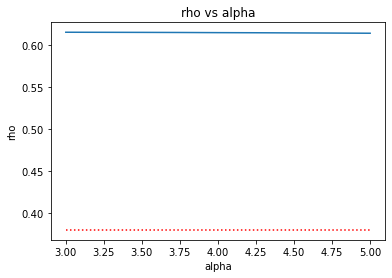

In [88]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    import nltk
    nltk.download('wordnet')
    
    from nltk.corpus import wordnet
    import retrofitting
    from retrofitting import Retrofitter

    dev_df = pd.read_csv(os.path.join(DATA_HOME, "cs224u-wordrelatedness-dev.csv"))
    count_df = pd.read_csv(os.path.join(VSM_HOME, 'giga_window20-flat.csv.gz'), index_col=0)
    
    k = 100
    pipeline = vsm.lsa(vsm.pmi(count_df), k)
    
    wordnet_edges = defaultdict(set)
    for st in wordnet.all_synsets():
        names = {l.name() for l in st.lemmas()}
        for n in names:
            wordnet_edges[n] |= set(names)
    
    index_edges = defaultdict(set)
    d = dict(zip(pipeline.index, range(pipeline.shape[0])))
    for key, val in wordnet_edges.items():
        start = d.get(key)
        if not start:
            continue
        finish = {d[n] for n in val if n in d}
        if not finish:
            continue
        index_edges[start] = finish
    
    # Testing only, comment this out.
    alphas = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
    #alphas = [3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]
    #alphas = [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5]
    #alphas = [4, 6, 8, 10, 12, 14, 16, 18, 20]
    rhos = []
    
    for a in alphas:
        test_retrofit = Retrofitter(alpha=lambda x: a, verbose=True)
        retro_df = test_retrofit.fit(pipeline, index_edges)
        pred, rho = vsm.word_relatedness_evaluation(dev_df, retro_df)
        rhos.append(rho)
        print("====\nAlpha: {0}\n\tPrediction: {1}\n\tRho: {2}".format(a, pred, rho))
    
    import matplotlib
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.set(xlabel='alpha', ylabel='rho', title='rho vs alpha')
    ax.plot(alphas, rhos)
    ax.hlines(0.38, alphas[0], alphas[len(alphas) - 1], colors='red', linestyles='dotted', label='ppmi-lsa')
    plt.show()
    
    # Code to actually submit.
    """ 
    retrofit = Retrofitter(alpha=lambda x: 10, verbose=True)
    retro_df = retrofit.fit(pipeline, index_edges)
    
    pred, rho = vsm.word_relatedness_evaluation(dev_df, retro_df)
    print("Prediction: {0}, rho: {1}".format(pred, rho))
    retro_df.to_csv("hw1_out_retro_df.csv")
    """
            
    

# STOP COMMENT: Please do not remove this comment.

## Bake-off [1 point]

For the bake-off, you simply need to evaluate your original system on the file 

`wordrelatedness/cs224u-wordrelatedness-test-unlabeled.csv`

This contains only word pairs (no scores), so `vsm.word_relatedness_evaluation` will simply make predictions without doing any scoring. Use that function to make predictions with your original system, store the resulting `pred_df` to a file, and then upload the file as your bake-off submission.

The following function should be used to conduct this evaluation:

In [ ]:
def create_bakeoff_submission(
        vsm_df,
        distfunc,
        output_filename="cs224u-wordrelatedness-bakeoff-entry.csv"):

    test_df = pd.read_csv(
        os.path.join(DATA_HOME, "cs224u-wordrelatedness-test-unlabeled.csv"))

    pred_df, _ = vsm.word_relatedness_evaluation(test_df, vsm_df, distfunc=distfunc)

    pred_df.to_csv(output_filename)

For example, if `count_df` were the VSM for my system, and I wanted my distance function to be `vsm.euclidean`, I would do

In [ ]:
create_bakeoff_submission(count_df, vsm.euclidean)

This creates a file `cs224u-wordrelatedness-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in `pred_df` – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.

## Submission Instruction

Submit the following files to gradescope submission

- Please do not change the file name as described below
- `hw_wordrelatedness.ipynb` (this notebook)
- `cs224u-wordrelatedness-bakeoff-entry.csv` (bake-off output)
